In [1]:
## Imports
import numpy as np
import torch
from PIL import Image
import os.path
import argparse
from pathlib import Path
import cv2
import heapq
from torch.nn import functional as F
from torch.utils.data import DataLoader
import tqdm
import einops
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt

/home/yossi_gandelsman/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
## Hyperparameters

device = 'cuda:0'
pretrained = 'laion2b_s32b_b82k' # 'laion2b_s32b_b79k'
model_name = 'ViT-L-14' # 'ViT-H-14'
batch_size = 8 # only needed for the nn search
imagenet_path = '/datasets/ilsvrc_2024-01-04_1601/' # only needed for the nn search

In [3]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=False) # This makes things faster!

Model parameters: 427,616,513
Context length: 77
Vocab size: 49408
Len of res: 24


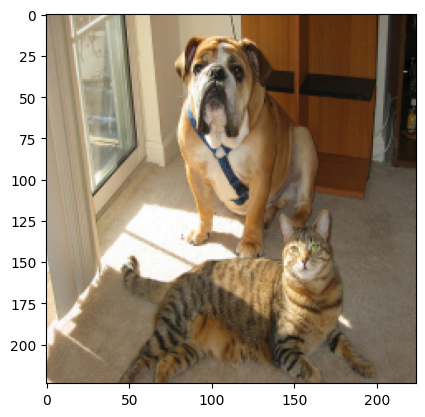

In [4]:
## Load image

image_pil = Image.open('images/catdog.png')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [5]:
## Run the image:
prs.reinit()
with torch.no_grad():
    representation = model.encode_image(image.to(device), 
                                        attn_method='head_no_spatial', 
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 32, 16, 1024], mlps: [1, 33, 1024]

In [6]:
## Create the pool for the nn search

ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess) # For showing images
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) # For running the model
dataloader = DataLoader(
    ds, batch_size=batch_size, shuffle=False, num_workers=8
)

In [7]:
## Define the head for which you want to search (e.g. "counting" head)

search_head = (20, 4) # (layer, head), try also - (23, 8) for color head

query = attentions[0, search_head[0], search_head[1]]

In [8]:
## Go over and search greedily (alternatively, use the precomputed values)

db = [(-float("inf"), None) for _ in range(15)]
for index, (images, _) in tqdm.tqdm(enumerate(dataloader)):
    images = images.to(device)
    with torch.no_grad():
        prs.reinit()
        current_representation = model.encode_image(images, 
                                                    attn_method='head_no_spatial', 
                                                    normalize=False)
        current_attentions, _ = prs.finalize(current_representation)  # attentions: [batch_size, layers, heads, repr_size]
        scores = current_attentions[:, search_head[0], search_head[1]] @ query
        for i in range(min(batch_size, images.shape[0])):
            heapq.heappushpop(db, (scores[i], batch_size * index + i))
db = sorted(db, key=lambda x: -x[0])

6250it [16:23,  6.36it/s]


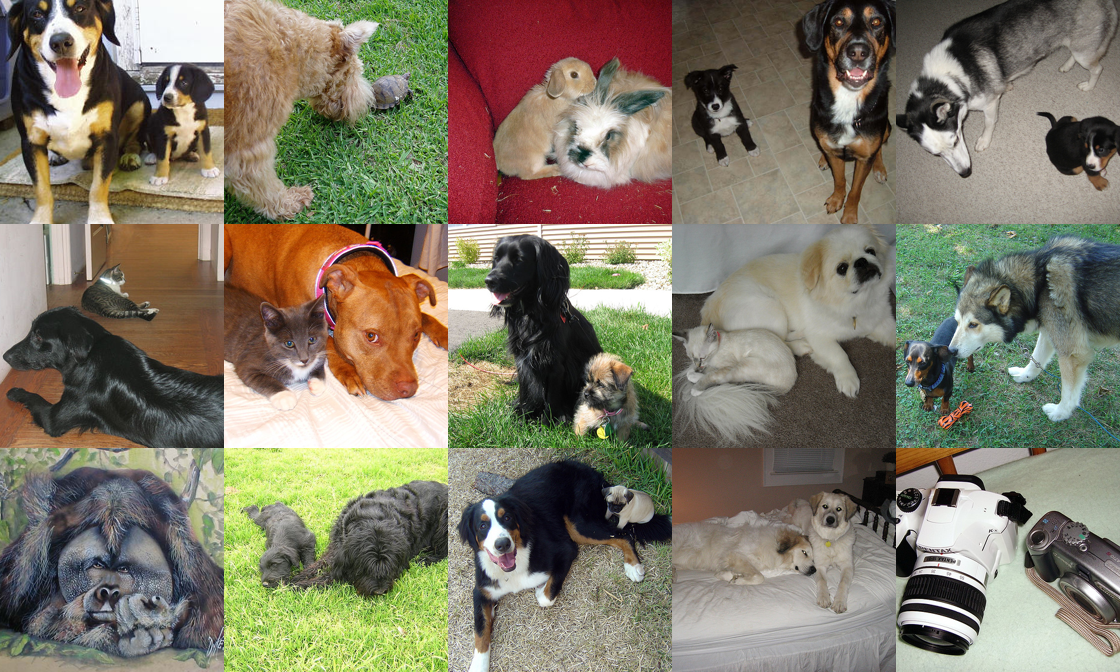

In [9]:
# Plot the top images in a grid:
images = []
for image_index in db:
    images.append(ds_vis[image_index[1]][0])
image_grid(images, 3, 5)